### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [2]:
# Visualization
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go

In [3]:
#!conda install -c conda-forge lightgbm --yes
#!conda install -c conda-forge xgboost --yes
#!conda install -c conda-forge plotly --yes

In [4]:
#pip install lightgbm
#pip install xgboost
#!pip install plotly

In [5]:
# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [6]:
# ML
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as ltb
from lightgbm import LGBMRegressor

import xgboost as xg
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [7]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.set_option("display.float_format", "{:.3f}".format)

In [8]:
RANDOM_SEED = 20210925
!pip freeze > requirements.txt

### Подготовка функций

In [9]:
def hist_descr(col):
    title = col.split('_')[1] + "_" + col.split('_')[-1]
    
    fig, ax = plt.subplots(1, 1, figsize = (5, 3))
    ax.hist(df[col], bins = 50);
    ax.set_title(title)

    plt.tight_layout()
    plt.show()
    
    print(df[col].describe()[['mean', 'std', 'min', '50%', 'max']].round(2).reset_index().
            to_csv(header=None, index=None, sep='\t'))

In [10]:
def correl(X):
    corr = df[X].corr()
    sns.set(font_scale=0.9)
    plt.subplots(figsize=(9, 6))
    plt.tight_layout()
    sns.heatmap(corr.abs(), square=True, vmin=0, vmax=1,
                annot=True, fmt=".1f", linewidths=0.1, cmap="icefire");

### Загрузка датасетов

In [12]:
df_train = pd.read_csv('/.../data/train.csv')
df_test = pd.read_csv('/.../data/test.csv')

print(df_train.shape, df_test.shape)

(279792, 77) (2974, 76)


In [13]:
df_test['target_price'] = 0
df_train['target_price'] = df_train.per_square_meter_price
df_train.drop('per_square_meter_price', axis=1, inplace=True)

df_train['sample'] = 1
df_test['sample'] = 0

In [14]:
# Объединим данные в единый датасет для приведения к единому формату

df = df_train.append(df_test, sort=False).reset_index(drop=True)
del df_train, df_test
df.shape

(282766, 78)

### Обработка пропусков

In [23]:
#df.isna().sum()

In [16]:
# Обозначаем какие изначально записи имели пропуски
df['na_house_1000'] = pd.isna(df['reform_house_population_1000']).astype('float64')
df['na_house_500'] = pd.isna(df['reform_house_population_500']).astype('float64')
df['na_floor_1000'] = pd.isna(df['reform_mean_floor_count_1000']).astype('float64')
df['na_floor_500'] = pd.isna(df['reform_mean_floor_count_500']).astype('float64')
df['na_yearb_1000'] = pd.isna(df['reform_mean_year_building_1000']).astype('float64')
df['na_yearb_500'] = pd.isna(df['reform_mean_year_building_500']).astype('float64')

In [17]:
isna_cols = ['reform_house_population_1000', 'reform_house_population_500', 'reform_mean_floor_count_1000',
             'reform_mean_floor_count_500', 'reform_mean_year_building_1000', 'reform_mean_year_building_500']

# Заполнение модой - по трейн выборке, так что лика по дате нет
for c in isna_cols:
        print(c , '\t', df[df['sample'] == 1][c].mode()[0].round(0)) #.astype('int64'))

reform_house_population_1000 	 0.0
reform_house_population_500 	 0.0
reform_mean_floor_count_1000 	 2.0
reform_mean_floor_count_500 	 5.0
reform_mean_year_building_1000 	 1963.0
reform_mean_year_building_500 	 1964.0


Далее каскад мероприятий по замене отсутствующих значений наиболее частым значением в train

In [18]:
# Замена всех пропущенных значений (на основе данных train)

df.reform_house_population_1000 = df.apply(lambda row: 0 
                                           if pd.isna(row.reform_house_population_1000) 
                                           else row.reform_house_population_1000, axis=1)

In [19]:
df.reform_house_population_500 = df.apply(lambda row: 0 
                                          if pd.isna(row.reform_house_population_500) 
                                          else row.reform_house_population_500, axis=1)

In [20]:
df.reform_mean_floor_count_1000 = df.apply(lambda row: 2
                                           if pd.isna(row.reform_mean_floor_count_1000) 
                                           else row.reform_mean_floor_count_1000, axis=1)

In [21]:
df.reform_mean_floor_count_500 = df.apply(lambda row: 5
                                          if pd.isna(row.reform_mean_floor_count_500) 
                                          else row.reform_mean_floor_count_500, axis=1)

In [22]:
df.reform_mean_year_building_1000 = df.apply(lambda row: 1963
                                             if pd.isna(row.reform_mean_year_building_1000) 
                                             else row.reform_mean_year_building_1000, axis=1)

In [23]:
df.reform_mean_year_building_500 = df.apply(lambda row: 1964
                                            if pd.isna(row.reform_mean_year_building_500) 
                                            else row.reform_mean_year_building_500, axis=1)

In [25]:
df.osm_city_nearest_population = df.apply(lambda row: 
                                           df[df.region == row.region].osm_city_nearest_population.median() if
                                           pd.isna(row.osm_city_nearest_population) else 
                                           row.osm_city_nearest_population, axis=1)

In [26]:
df.shape

(282766, 84)

### Проверка автокорреляции признаков OSM
#### И удаление наиболее взаимосвязанных

In [27]:
# Перенос текстового признака в конец таблицы

df['city_nearest_name'] = df['osm_city_nearest_name']
df.drop('osm_city_nearest_name', axis=1, inplace=True)

In [31]:
df.columns

Index(['city', 'floor', 'id', 'lat', 'lng', 'osm_amenity_points_in_0.001',
       'osm_amenity_points_in_0.005', 'osm_amenity_points_in_0.0075',
       'osm_amenity_points_in_0.01', 'osm_building_points_in_0.001',
       'osm_building_points_in_0.005', 'osm_building_points_in_0.0075',
       'osm_building_points_in_0.01', 'osm_catering_points_in_0.001',
       'osm_catering_points_in_0.005', 'osm_catering_points_in_0.0075',
       'osm_catering_points_in_0.01', 'osm_city_closest_dist',
       'osm_city_nearest_population', 'osm_crossing_closest_dist',
       'osm_crossing_points_in_0.001', 'osm_crossing_points_in_0.005',
       'osm_crossing_points_in_0.0075', 'osm_crossing_points_in_0.01',
       'osm_culture_points_in_0.001', 'osm_culture_points_in_0.005',
       'osm_culture_points_in_0.0075', 'osm_culture_points_in_0.01',
       'osm_finance_points_in_0.001', 'osm_finance_points_in_0.005',
       'osm_finance_points_in_0.0075', 'osm_finance_points_in_0.01',
       'osm_healthcare_p

In [32]:
X1 = list(df.columns[5:13])
X1

['osm_amenity_points_in_0.001',
 'osm_amenity_points_in_0.005',
 'osm_amenity_points_in_0.0075',
 'osm_amenity_points_in_0.01',
 'osm_building_points_in_0.001',
 'osm_building_points_in_0.005',
 'osm_building_points_in_0.0075',
 'osm_building_points_in_0.01']

In [33]:
#correl(X1)

In [34]:
X1.remove('osm_building_points_in_0.005')
X1.remove('osm_building_points_in_0.0075')
X1.remove('osm_building_points_in_0.01')

X1.remove('osm_amenity_points_in_0.005')
X1.remove('osm_amenity_points_in_0.0075')
X1.remove('osm_amenity_points_in_0.01')

In [35]:
X2 = list(df.columns[13:24])
X2

['osm_catering_points_in_0.001',
 'osm_catering_points_in_0.005',
 'osm_catering_points_in_0.0075',
 'osm_catering_points_in_0.01',
 'osm_city_closest_dist',
 'osm_city_nearest_population',
 'osm_crossing_closest_dist',
 'osm_crossing_points_in_0.001',
 'osm_crossing_points_in_0.005',
 'osm_crossing_points_in_0.0075',
 'osm_crossing_points_in_0.01']

In [36]:
#correl(X2)

In [37]:
X2.remove('osm_crossing_points_in_0.005')
X2.remove('osm_crossing_points_in_0.0075')
X2.remove('osm_crossing_points_in_0.01')

X2.remove('osm_catering_points_in_0.005')
X2.remove('osm_catering_points_in_0.0075')
X2.remove('osm_catering_points_in_0.01')

In [38]:
X3 = list(df.columns[24:35])
X3

['osm_culture_points_in_0.001',
 'osm_culture_points_in_0.005',
 'osm_culture_points_in_0.0075',
 'osm_culture_points_in_0.01',
 'osm_finance_points_in_0.001',
 'osm_finance_points_in_0.005',
 'osm_finance_points_in_0.0075',
 'osm_finance_points_in_0.01',
 'osm_healthcare_points_in_0.005',
 'osm_healthcare_points_in_0.0075',
 'osm_healthcare_points_in_0.01']

In [39]:
#correl(X3)

In [40]:
X3.remove('osm_culture_points_in_0.005')
X3.remove('osm_culture_points_in_0.0075')
X3.remove('osm_culture_points_in_0.01')

X3.remove('osm_finance_points_in_0.005')
X3.remove('osm_finance_points_in_0.0075')
X3.remove('osm_finance_points_in_0.01')

X3.remove('osm_healthcare_points_in_0.0075')
X3.remove('osm_healthcare_points_in_0.01')

In [41]:
X4 = list(df.columns[35:44])
X4

['osm_historic_points_in_0.005',
 'osm_historic_points_in_0.0075',
 'osm_historic_points_in_0.01',
 'osm_hotels_points_in_0.005',
 'osm_hotels_points_in_0.0075',
 'osm_hotels_points_in_0.01',
 'osm_leisure_points_in_0.005',
 'osm_leisure_points_in_0.0075',
 'osm_leisure_points_in_0.01']

In [42]:
#correl(X4)

In [43]:
X4.remove('osm_historic_points_in_0.0075')
X4.remove('osm_historic_points_in_0.01')

X4.remove('osm_hotels_points_in_0.0075')
X4.remove('osm_hotels_points_in_0.01')

X4.remove('osm_leisure_points_in_0.0075')
X4.remove('osm_leisure_points_in_0.01')

In [44]:
X5 = list(df.columns[44:52])
X5

['osm_offices_points_in_0.001',
 'osm_offices_points_in_0.005',
 'osm_offices_points_in_0.0075',
 'osm_offices_points_in_0.01',
 'osm_shops_points_in_0.001',
 'osm_shops_points_in_0.005',
 'osm_shops_points_in_0.0075',
 'osm_shops_points_in_0.01']

In [45]:
#correl(X5)

In [46]:
X5.remove('osm_offices_points_in_0.005')
X5.remove('osm_offices_points_in_0.0075')
X5.remove('osm_offices_points_in_0.01')

X5.remove('osm_shops_points_in_0.005')
X5.remove('osm_shops_points_in_0.0075')
X5.remove('osm_shops_points_in_0.01')

In [47]:
X6 = list(df.columns[52:61])
X6

['osm_subway_closest_dist',
 'osm_train_stop_closest_dist',
 'osm_train_stop_points_in_0.005',
 'osm_train_stop_points_in_0.0075',
 'osm_train_stop_points_in_0.01',
 'osm_transport_stop_closest_dist',
 'osm_transport_stop_points_in_0.005',
 'osm_transport_stop_points_in_0.0075',
 'osm_transport_stop_points_in_0.01']

In [48]:
#correl(X6)

In [49]:
X6.remove('osm_train_stop_points_in_0.0075')
X6.remove('osm_train_stop_points_in_0.01')

X6.remove('osm_transport_stop_points_in_0.0075')
X6.remove('osm_transport_stop_points_in_0.01')

In [50]:
X7 = list(df.columns[61:69])
X7

['reform_count_of_houses_1000',
 'reform_count_of_houses_500',
 'reform_house_population_1000',
 'reform_house_population_500',
 'reform_mean_floor_count_1000',
 'reform_mean_floor_count_500',
 'reform_mean_year_building_1000',
 'reform_mean_year_building_500']

In [51]:
#correl(X7)

In [52]:
X7.remove('reform_count_of_houses_1000')
X7.remove('reform_house_population_1000')
X7.remove('reform_mean_floor_count_1000')
X7.remove('reform_mean_year_building_1000')

In [53]:
# Агрегируем оставшиеся признаки 

X_osm = X1+X2+X3+X4+X5+X6+X7

#correl(X_osm)

In [54]:
X_osm.remove('osm_amenity_points_in_0.001')
X_osm.remove('osm_crossing_closest_dist')
#X_osm.remove('osm_healthcare_points_in_0.005')
#X_osm.remove('osm_catering_points_in_0.001')
#X_osm.remove('osm_catering_points_in_0.001')

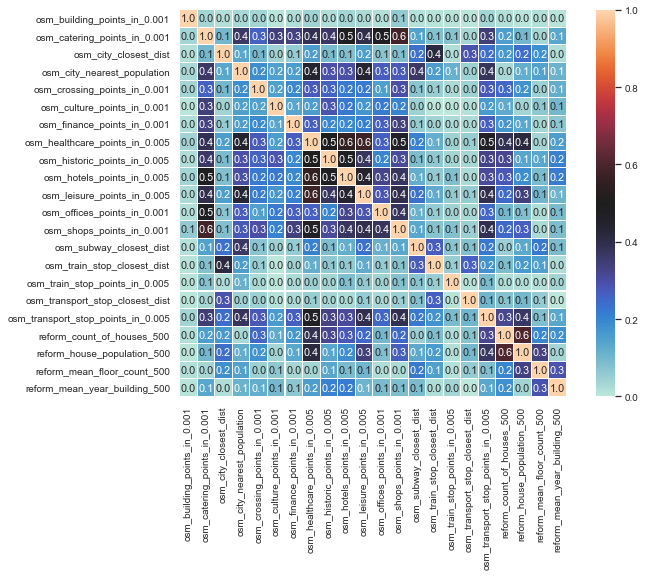

In [55]:
correl(X_osm)

**На этом этапе логарифмируем числовые признаки OSM и посмотрим, где это могло принести пользу**

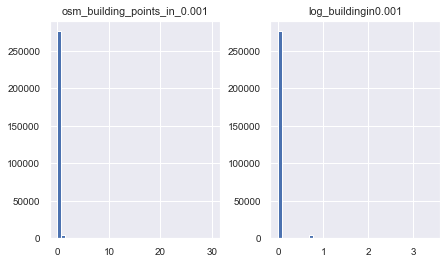

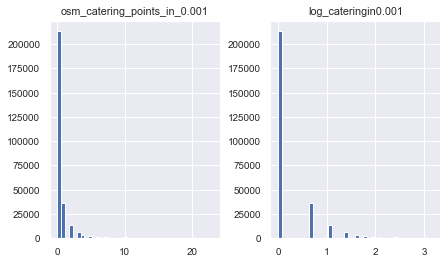

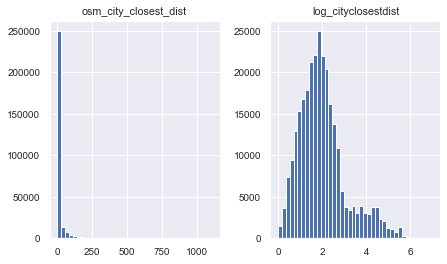

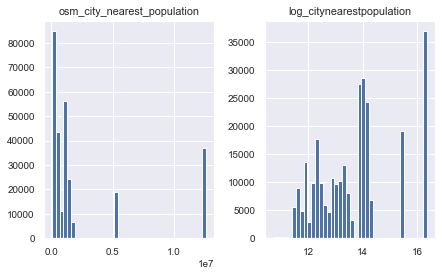

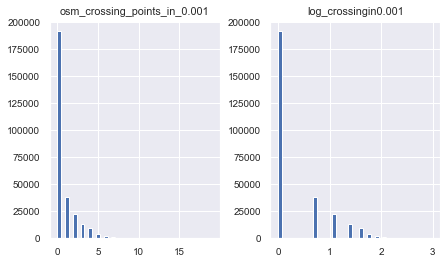

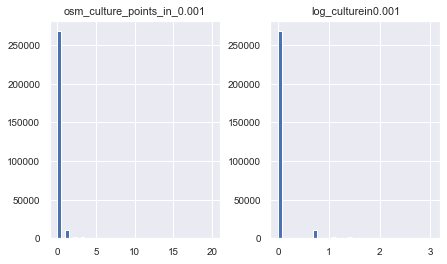

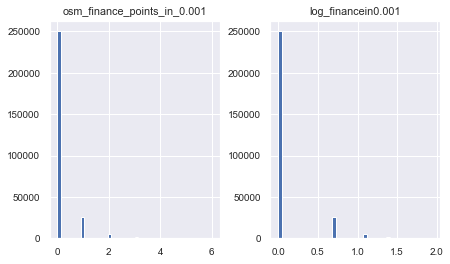

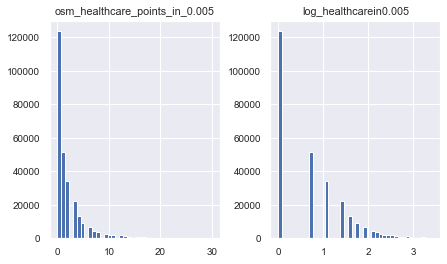

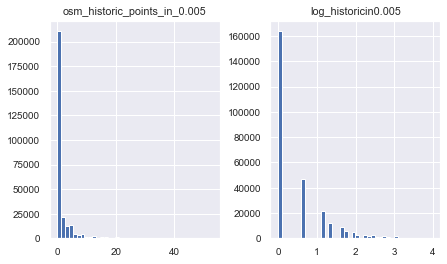

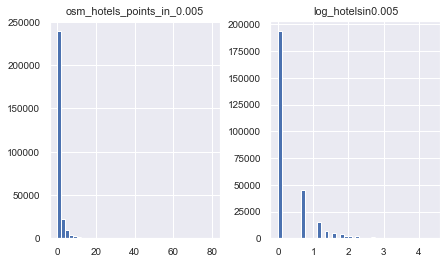

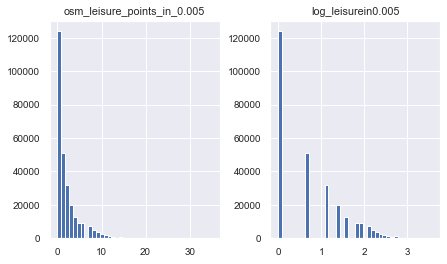

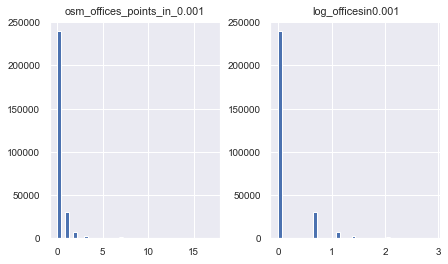

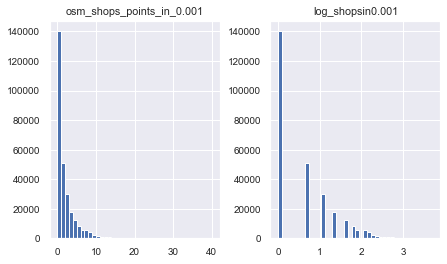

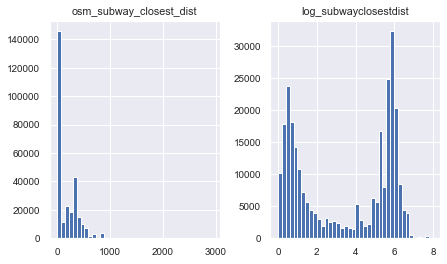

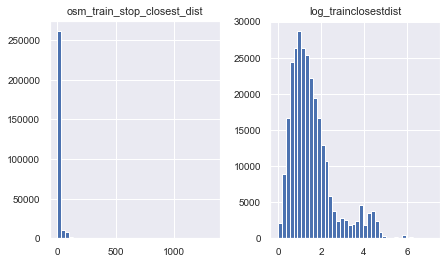

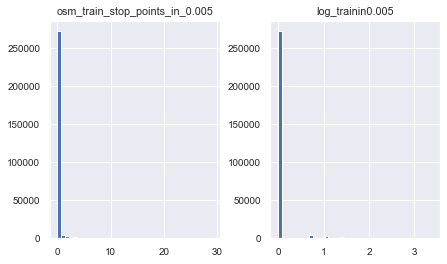

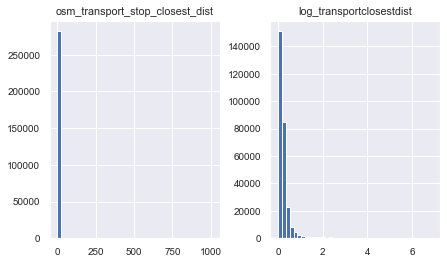

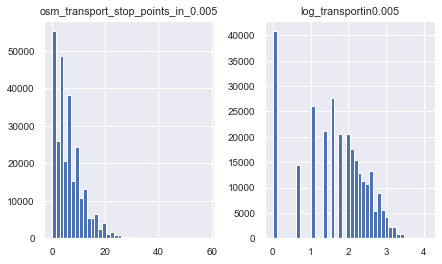

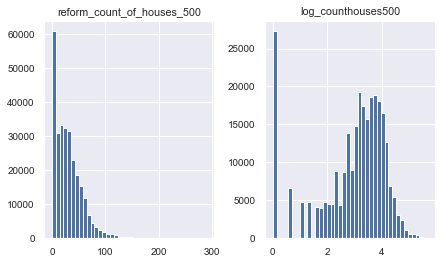

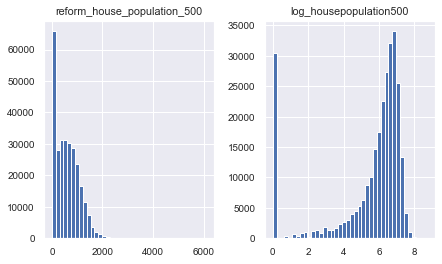

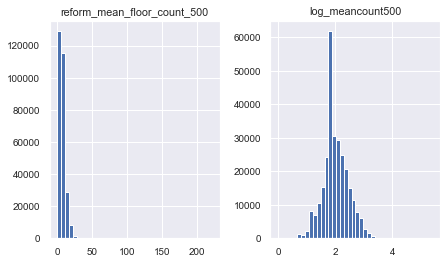

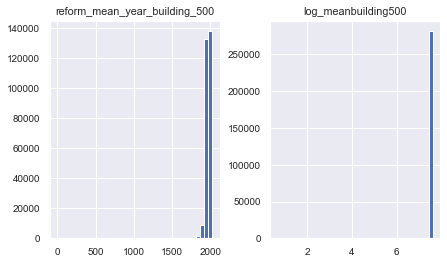

In [56]:
X_log_osm = []
for col in X_osm:
    title = 'log_' + col.split('_')[1] + col.split('_')[-2] + col.split('_')[-1]
    X_log_osm.append(title)
    df[title] = np.log(df[col] + 1)
    df[[col, title]].hist(figsize=(7, 4), bins=40);

In [57]:
#correl(X_log_osm)

In [63]:
X_log_osm.remove('log_transportin0.005')
X_log_osm.remove('log_cateringin0.001')
X_log_osm.remove('log_healthcarein0.005')
X_log_osm.remove('log_leisurein0.005')
X_log_osm.remove('log_housepopulation500')

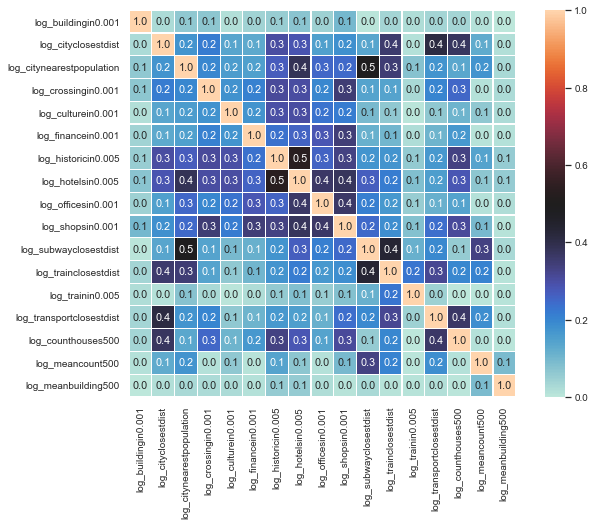

In [64]:
correl(X_log_osm)

#### Логарифмируем так же площадь недвижимости и целевую переменную - стоимость 1 кв. метра

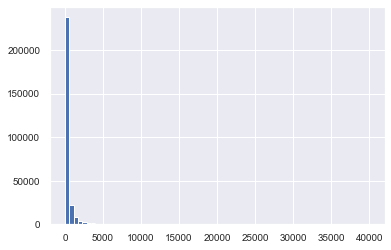

In [66]:
df.total_square.hist(bins=50);

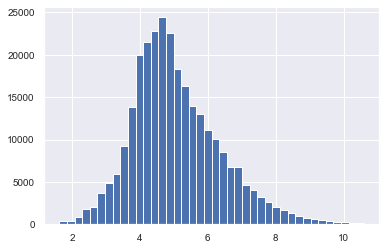

In [67]:
df['log_square'] = np.log(df['total_square'])
df['log_square'].hist(bins=50);

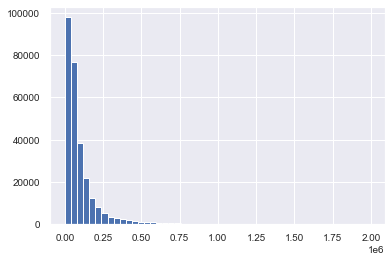

In [68]:
df.target_price.hist(bins=50);

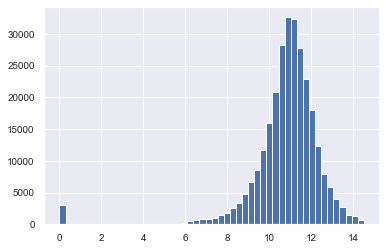

In [69]:
df['log_target'] = np.log(np.where(df['sample'] == 1, df.target_price, 1))
# для тестовой выборки - логарифмирование целевой переменной не важно, будет 0
df.log_target.hist(bins=50);

Показатель типа жилья закодируем

### Обработка даты

In [70]:
# Приведём даты к общему формату

df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d', errors='coerce')

In [71]:
# Выделим значения г-м-д

df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day

In [72]:
# Посмотрим на временные периоды в данных

df.groupby('sample')['month'].value_counts(dropna=False)

sample  month
0       11         939
        12         817
        9          623
        10         595
1       6        39068
        3        37628
        2        36649
        7        36145
        5        34938
        1        34881
        8        32783
        4        27700
Name: month, dtype: int64

### Отображение даты и месяца на круг

12-й месяц не сильно отличается от 1-го, на практике это очень близкие значения. Так же и 31-е и 1-е числа очень близки. Но модель этого не знает, поэтому лучше будет отображать зацикленные данные в виде "циферблата". Для этого заменим показатели месяца/даты на функции синуса и косинуса. 

In [73]:
# Словарь с общим количеством дней в месяцах 2020 года

days_in_month = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 13:31}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


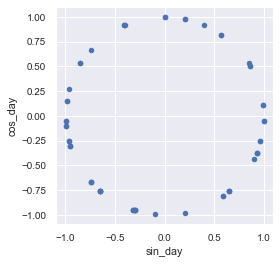

In [74]:
df['sin_day'] = np.sin(2*np.pi*df.day/df.month.map(days_in_month))
df['cos_day'] = np.cos(2*np.pi*df.day/df.month.map(days_in_month))

df.drop('day', axis=1, inplace=True)

df.sample(60).plot.scatter('sin_day', 'cos_day').set_aspect('equal');

In [75]:
# За одно добавим признак времени года

seasons = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 
           7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11: 'autumn', 12: 'winter'}

df['season'] = df.month.map(seasons)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


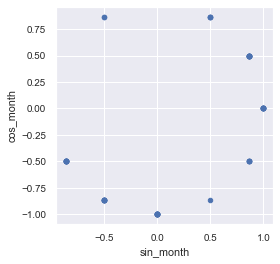

In [76]:
# Аналогично датам обработаем данные по месяцам

df['sin_month'] = np.sin(2*np.pi*df.month/12)
df['cos_month'] = np.cos(2*np.pi*df.month/12)

df.drop('month', axis=1, inplace=True)

df.sample(60).plot.scatter('sin_month', 'cos_month').set_aspect('equal');

In [77]:
#Итоговые рабочие признаки для модели
X_check = X_log_osm + ['log_square', 'realty_type', 'price_type'] + \
                      ['sin_day', 'cos_day', 'sin_month', 'cos_month'] + \
                      ['na_floor_1000', 'na_floor_500', 'na_house_1000', 
                       'na_house_500', 'na_yearb_1000', 'na_yearb_500'] + ['log_target', 'sample']

In [78]:
print(df[df['sample'] == 1][X_check].shape, df[df['sample'] == 0][X_check].shape)

(279792, 32) (2974, 32)


### OneHotEncoder

На этом этапе будем дополнять новый df с переменными, которые будут использованы в обучении

#### Попробуем сделать dummy для укрупненного признака по населению (10к)

In [79]:
df['pop_thnd'] = round(df.osm_city_nearest_population / 10000, 0).astype('int64')
df['pop_thnd'].value_counts(dropna=False)[:5]

1263    36933
538     19131
140     14657
125     12185
22      10123
Name: pop_thnd, dtype: int64

In [80]:
OHE = OneHotEncoder(sparse=False)

In [81]:
# Кодируем население по 10к

popul100k = OHE.fit_transform(df.pop_thnd.values.reshape(-1,1))
pop_tmp = pd.DataFrame(popul100k, columns=['pop_' + str(i) for i in range(len(popul100k[0]))])

In [82]:
df_check = pd.concat([df[X_check], pop_tmp], axis=1)
df_check.shape

(282766, 100)

In [83]:
# Кодируем время года

seas = OHE.fit_transform(df.season.values.reshape(-1,1))
seas_tmp = pd.DataFrame(seas, columns=['season_' + str(i) for i in range(len(seas[0]))])

In [84]:
df_check = pd.concat([df_check, seas_tmp], axis=1)
df_check.shape

(282766, 104)

In [85]:
# Кодируем realty_type

realty_t = OHE.fit_transform(df.realty_type.values.reshape(-1,1))
rt_tmp = pd.DataFrame(realty_t, columns=['realty_' + str(i) for i in range(len(realty_t[0]))])

In [86]:
df_check = pd.concat([df_check, rt_tmp], axis=1)
df_check.shape

(282766, 107)

In [87]:
# Кодируем названия областей

region_ohe = OHE.fit_transform(df.region.values.reshape(-1,1))
tmp_reg = pd.DataFrame(region_ohe, columns=['reg_' + str(i) for i in range(len(region_ohe[0]))])

In [88]:
df_check = pd.concat([df_check, tmp_reg], axis=1)
df_check.shape

(282766, 156)

### Создание  модели

In [91]:
# выделяем обратно train

X = df_check[df_check['sample'] == 1].drop(['log_target', 'sample'], axis=1)
X.shape

(279792, 154)

In [93]:
y = df_check[df_check['sample'] == 1]['log_target']
y.shape

(279792,)

In [94]:
# Перед обучением основных данных -
# Пробная попытка - взять из train только price_type = 1 (как в валидационной выборке)

Xs = df_check[(df_check['sample'] == 1) & (df_check['price_type'] == 1)].drop(['log_target', 'sample'], axis=1)
Xs.shape

(4493, 154)

In [95]:
ys = df_check[(df_check['sample'] == 1)  & (df_check['price_type'] == 1)]['log_target']
ys.shape

(4493,)

In [96]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=RANDOM_SEED)
print(Xs_train.shape, Xs_test.shape, ys_train.shape, ys_test.shape)

(3594, 154) (899, 154) (3594,) (899,)


XGB

In [97]:
params = {
    'max_depth': 8,
    'gamma': 0,
    'eta': .01,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0
}

In [98]:
matrix_train = xg.DMatrix(Xs_train, label=ys_train)
matrix_test = xg.DMatrix(Xs_test, label=ys_test)

In [99]:
start_time = dt.now()
model = xg.train(params=params, dtrain=matrix_train, num_boost_round=1500,
                 early_stopping_rounds=5, evals=[(matrix_test, 'test')])

[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	test-rmse:10.28968
[1]	test-rmse:10.18673
[2]	test-rmse:10.08482
[3]	test-rmse:9.98388
[4]	test-rmse:9.88399
[5]	test-rmse:9.78508
[6]	test-rmse:9.68716
[7]	test-rmse:9.59019
[8]	test-rmse:9.49428
[9]	test-rmse:9.39922
[10]	test-rmse:9.30517
[11]	test-rmse:9.21208
[12]	test-rmse:9.11991
[13]	test-rmse:9.02873
[14]	test-rmse:8.93838

In [101]:
print("Training time: %i seconds with %i training examples" %
      ((dt.now()-start_time).total_seconds(), len(ys_train)))

Training time: 27 seconds with 3594 training examples


In [102]:
ys_pred = model.predict(xg.DMatrix(Xs_test))

In [103]:
print('MAE:', round(mean_absolute_error(ys_test, ys_pred), 3))  
print('MSE:', round(mean_squared_error(ys_test, ys_pred), 3))  
print('RMSE:', round(np.sqrt(mean_squared_error(ys_test, ys_pred)), 3))
print('VarScore:', round(explained_variance_score(ys_test, ys_pred), 3))

MAE: 0.228
MSE: 0.101
RMSE: 0.318
VarScore: 0.694


### Запуск на валидационной выборке и сабмишн

In [104]:
test_sub = pd.read_csv('/.../data/test_submission.csv')
test_sub.head()

,id,per_square_meter_price
0,COL_289284,0
1,COL_289305,0
2,COL_289318,0
3,COL_289354,0
4,COL_289399,0


In [105]:
len(test_sub)

2974

In [106]:
X_val = df_check[df_check['sample'] == 0].drop(['log_target', 'sample'], axis=1)
print(len(X_val))

2974


In [107]:
predict_sub = model.predict(xg.DMatrix(X_val))

In [108]:
predict_sub = np.exp(predict_sub)
pd.Series(predict_sub).head()

0   50389.375
1   42758.465
2   46125.113
3   81192.008
4   57245.148
dtype: float32

In [109]:
test_sub['per_square_meter_price'] = predict_sub
test_sub.to_csv('submission3.csv', index=False)
test_sub.head(10)

,id,per_square_meter_price
0,COL_289284,50389.375
1,COL_289305,42758.465
2,COL_289318,46125.113
3,COL_289354,81192.008
4,COL_289399,57245.148
5,COL_289428,44683.617
6,COL_289460,53684.656
7,COL_289493,49313.633
8,COL_289495,56275.633
9,COL_289749,49995.383
